# Multimodal Chatbot - Complete Assignment Implementation

This notebook implements a Multimodal AI Chatbot (Image + Text + Audio) tailored to meet all assignment requirements.


## 1. Environment Setup


In [ ]:
%pip install torch torchvision transformers opencv-python openai-whisper librosa streamlit scikit-learn matplotlib
import torch
import torchvision
import transformers
import cv2
import whisper
import librosa
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Note: you may need to restart the kernel to use updated packages.
Using device: cpu


In [7]:
%matplotlib inline


## 2. Data Acquisition & Exploration (FashionMNIST)


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Define transformations (Resize to 224 for ResNet, Convert to Tensor, Normalize)
# Define transformations
# Task 3.1: Apply augmentation techniques (Horizontal Flip, Rotation) + Resize & Normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), # Augmentation
    transforms.RandomRotation(degrees=15),  # Augmentation
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Download FashionMNIST
train_data_raw = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data_raw = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Training Samples: {len(train_data_raw)}")
print(f"Test Samples: {len(test_data_raw)}")
print(f"Classes: {class_names}")


Training Samples: 60000
Test Samples: 10000
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### 2.1 Visualize Samples


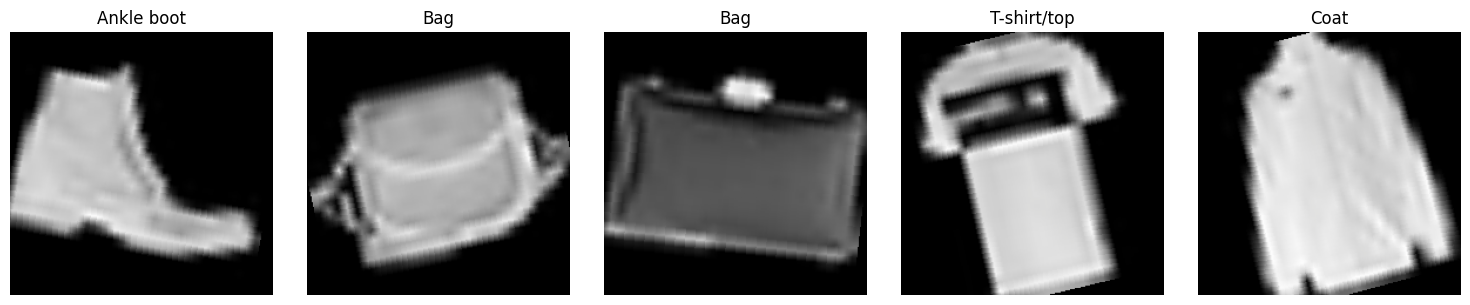

In [ ]:
def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        # Convert to numpy array for imshow
        img_np = img.numpy()
        axes[i].imshow(img_np)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_data_raw)

### 2.1.2 Class Distribution Analysis


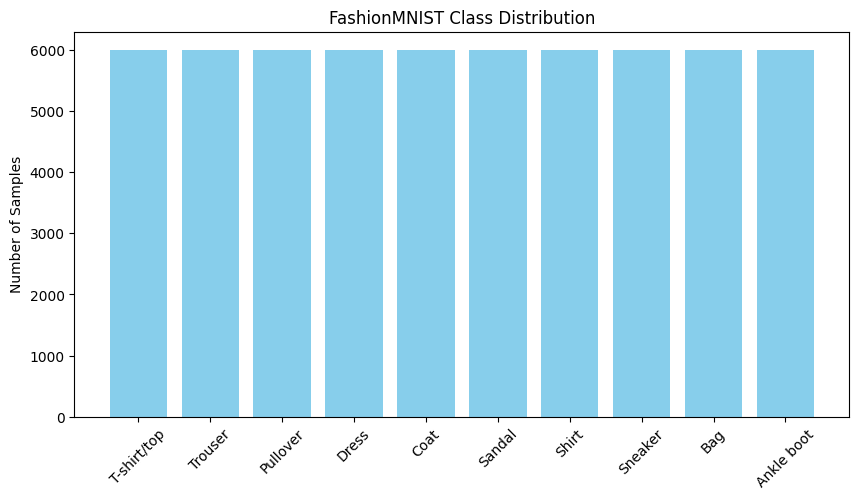

In [12]:
# Task 2.1: Plot class distributions
import collections

labels = [label for _, label in train_data_raw]
counter = collections.Counter(labels)
counts = [counter[i] for i in range(10)]

plt.figure(figsize=(10, 5))
plt.bar(class_names, counts, color='skyblue')
plt.title('FashionMNIST Class Distribution')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()


### 2.1.3 Comparative Analysis (Similar vs Dissimilar)


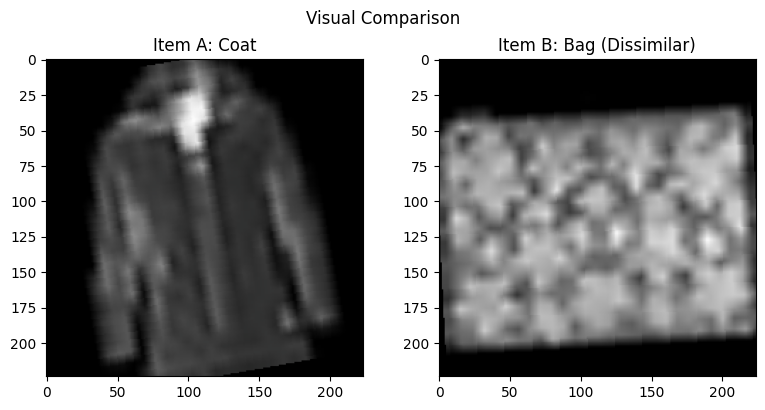

In [13]:
# Task 2.1: Compare example items
def show_comparison():
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Get two indices: one 'Coat' (4) and one 'Bag' (8) for dissimilar
    idx1 = [i for i, t in enumerate(train_data_raw.targets) if t == 4][0]
    idx2 = [i for i, t in enumerate(train_data_raw.targets) if t == 8][0]
    
    img1, _ = train_data_raw[idx1]
    img2, _ = train_data_raw[idx2]

    # Process for display
    def proc(img):
        img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        return img.numpy()  # Convert to numpy array

    axes[0].imshow(proc(img1))
    axes[0].set_title("Item A: Coat")
    
    axes[1].imshow(proc(img2))
    axes[1].set_title("Item B: Bag (Dissimilar)")
    
    plt.suptitle("Visual Comparison")
    plt.tight_layout()
    plt.show()

show_comparison()

### 2.2 Synthetic Multimodal Dataset Generation
To properly train a multimodal model, we need text paired with images. Since FashionMNIST is image-only, we will generate synthetic text descriptions based on the labels.


In [14]:
import random

colors = ['black', 'blue', 'red', 'green', 'white', 'striped', 'patterned']
styles = ['casual', 'formal', 'sporty', 'elegant', 'comfortable']

class MultimodalFashionDataset(Dataset):
    def __init__(self, fashion_mnist_dataset):
        self.dataset = fashion_mnist_dataset
        self.descriptions = []
        
        # Generate descriptions
        for _, label in self.dataset:
            label_name = class_names[label]
            color = random.choice(colors)
            style = random.choice(styles)
            text = f"A {style} {color} {label_name}."
            self.descriptions.append(text)
            
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        text = self.descriptions[idx]
        return img, text, label

# Create Multimodal Datasets (Using subset to speed up assignment demo)
subset_size = 2000 # Use 2000 samples for reasonable training time in demo
indices = torch.randperm(len(train_data_raw))[:subset_size]
train_subset = torch.utils.data.Subset(train_data_raw, indices)

multimodal_dataset = MultimodalFashionDataset(train_subset)

# Check a sample
img, txt, lbl = multimodal_dataset[0]
print(f"Sample Text: {txt}")
print(f"Label: {class_names[lbl]}")


Sample Text: A sporty white T-shirt/top.
Label: T-shirt/top


### 2.2.3 Text Data Analysis


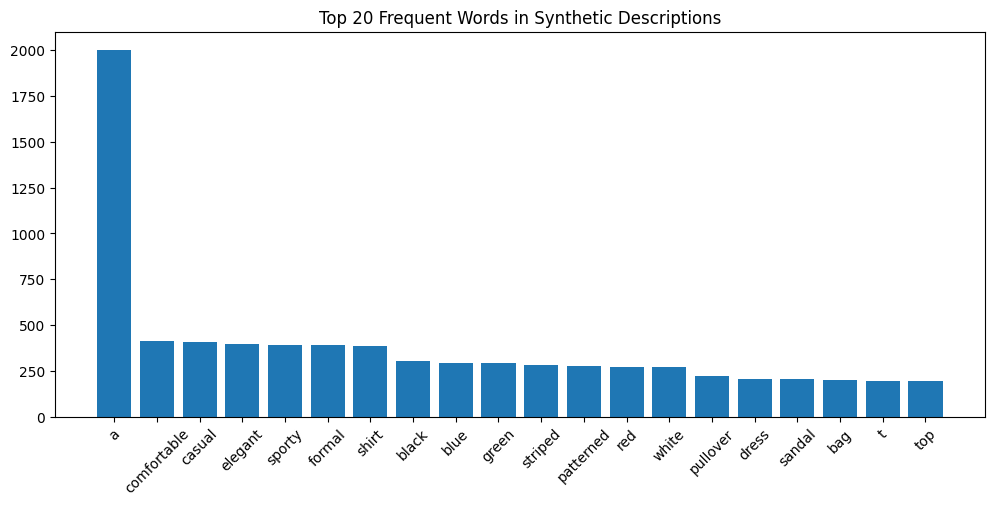

In [16]:
# Task 2.2: Analyse vocabulary
from collections import Counter
import re

all_text = " ".join(multimodal_dataset.descriptions)  # Directly join the list of descriptions
words = re.findall(r'\w+', all_text.lower())
word_counts = Counter(words)

# Plot top 20 words
common_words = word_counts.most_common(20)
plt.figure(figsize=(12, 5))
plt.bar([w[0] for w in common_words], [w[1] for w in common_words])
plt.title('Top 20 Frequent Words in Synthetic Descriptions')
plt.xticks(rotation=45)
plt.show()

## 3. Preprocessing Pipelines


### 3.1 Text Pipeline (BERT Tokenizer)


In [17]:

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=64, return_tensors='pt')

# Demo
sample_texts = [multimodal_dataset[0][1], multimodal_dataset[1][1]]
tokens = tokenize_text(sample_texts)
print(f"Token shape: {tokens['input_ids'].shape}")


Token shape: torch.Size([2, 64])


### 3.2 Audio Pipeline (MFCC Feature Extraction)


In [18]:
def extract_mfcc(audio_path, max_len=100):
    try:
        y, sr = librosa.load(audio_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        # Pad or truncate
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
        
        # Task 3.2: Normalise MFCC features
        mean = np.mean(mfcc)
        std = np.std(mfcc)
        mfcc = (mfcc - mean) / (std + 1e-6)
        
        return torch.tensor(mfcc, dtype=torch.float32)
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None



## 4. Model Design


In [19]:
import torch.nn as nn
import torchvision.models as models
from transformers import BertModel

class MultimodalClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(MultimodalClassifier, self).__init__()
        
        # Visual Encoder (ResNet50)
        self.visual_base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.visual_base.fc = nn.Identity() # Remove top layer
        # Freeze backbone
        for param in self.visual_base.parameters():
            param.requires_grad = False
            
        # Text Encoder (BERT)
        self.text_base = BertModel.from_pretrained('bert-base-uncased')
        # Freeze BERT
        for param in self.text_base.parameters():
            param.requires_grad = False
            
        # Fusion & Classification
        self.fc_visual = nn.Linear(2048, 512)
        self.fc_text = nn.Linear(768, 512)
        
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, images, input_ids, attention_mask):
        # Image Features
        v_feat = self.visual_base(images)
        v_feat = self.fc_visual(v_feat)
        
        # Text Features
        t_out = self.text_base(input_ids=input_ids, attention_mask=attention_mask)
        t_feat = t_out.last_hidden_state[:, 0, :] # CLS token
        t_feat = self.fc_text(t_feat)
        
        # Fusion (Concatenation)
        combined = torch.cat((v_feat, t_feat), dim=1)
        
        output = self.classifier(combined)
        return output

model = MultimodalClassifier(num_classes=10).to(device)
print("Model initialized.")


Model initialized.


## 5. Training & Evaluation


In [21]:
# Data Loader
# Task 3.3 Create train/validation splits
from torch.utils.data import random_split

train_size = int(0.8 * len(multimodal_dataset))
val_size = len(multimodal_dataset) - train_size
train_ds, val_ds = random_split(multimodal_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
print(f"Train Size: {len(train_ds)}, Validation Size: {len(val_ds)}")

# Optimization
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training Loop
num_epochs = 5 
train_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, texts, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Tokenize text on the fly
        encoded_text = tokenizer(list(texts), padding=True, truncation=True, max_length=64, return_tensors='pt')
        input_ids = encoded_text['input_ids'].to(device)
        attention_mask = encoded_text['attention_mask'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    
    # Validation Loop
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, texts, labels in val_loader:
             images = images.to(device)
             labels = labels.to(device)
             encoded = tokenizer(list(texts), padding=True, truncation=True, max_length=64, return_tensors='pt')
             outputs = model(images, encoded['input_ids'].to(device), encoded['attention_mask'].to(device))
             _, predicted = torch.max(outputs.data, 1)
             val_total += labels.size(0)
             val_correct += (predicted == labels).sum().item()
    
    val_acc = 100 * val_correct / val_total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), 'multimodal_model_improved.pth')
print("Model saved to 'multimodal_model_improved.pth'")


Train Size: 1600, Validation Size: 400
Starting training...
Epoch [1/5], Loss: 1.4872, Train Acc: 49.19%, Val Acc: 96.75%
Epoch [2/5], Loss: 0.1848, Train Acc: 95.25%, Val Acc: 100.00%
Epoch [3/5], Loss: 0.0495, Train Acc: 98.69%, Val Acc: 99.50%
Epoch [4/5], Loss: 0.0482, Train Acc: 98.62%, Val Acc: 100.00%
Epoch [5/5], Loss: 0.0248, Train Acc: 99.38%, Val Acc: 100.00%
Model saved to 'multimodal_model_improved.pth'


### 5.3 Detailed Evaluation Metrics


In [22]:
# Task 5.2: Evaluation Metrics (Precision, Recall, F1)
from sklearn.metrics import classification_report

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, texts, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        encoded = tokenizer(list(texts), padding=True, truncation=True, max_length=64, return_tensors='pt')
        outputs = model(images, encoded['input_ids'].to(device), encoded['attention_mask'].to(device))
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

 T-shirt/top       1.00      1.00      1.00        43
     Trouser       1.00      1.00      1.00        38
    Pullover       1.00      1.00      1.00        56
       Dress       1.00      1.00      1.00        43
        Coat       1.00      1.00      1.00        30
      Sandal       1.00      1.00      1.00        34
       Shirt       1.00      1.00      1.00        33
     Sneaker       1.00      1.00      1.00        40
         Bag       1.00      1.00      1.00        42
  Ankle boot       1.00      1.00      1.00        41

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



### 5.2 Plotting Results


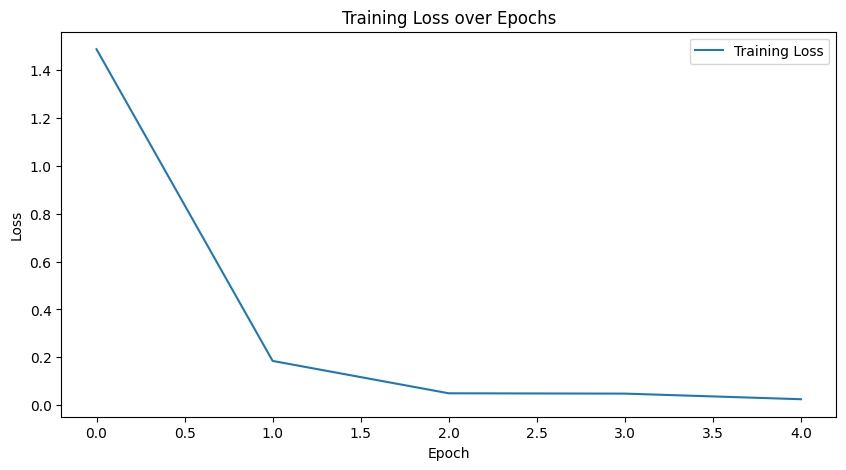

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 6. Deployment (Streamlit App)


This section generates the `app_complete.py` file which uses our trained model.


In [24]:
with open('app_complete.py', 'w') as f:
    f.write(r'''
import streamlit as st
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertTokenizer, BertModel
from torchvision import transforms
from PIL import Image
import whisper
import numpy as np
import io

# --- Model Definition (Must match training) ---
class MultimodalClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(MultimodalClassifier, self).__init__()
        self.visual_base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.visual_base.fc = nn.Identity()
        self.text_base = BertModel.from_pretrained('bert-base-uncased')
        self.fc_visual = nn.Linear(2048, 512)
        self.fc_text = nn.Linear(768, 512)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.3), nn.Linear(512, num_classes)
        )
        
    def forward(self, images, input_ids, attention_mask):
        v_feat = self.fc_visual(self.visual_base(images))
        t_out = self.text_base(input_ids=input_ids, attention_mask=attention_mask)
        t_feat = self.fc_text(t_out.last_hidden_state[:, 0, :])
        return self.classifier(torch.cat((v_feat, t_feat), dim=1))

# --- Utils ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

@st.cache_resource
def load_resources():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = MultimodalClassifier(num_classes=10)
    
    # Load Weights if available
    if os.path.exists('multimodal_model_improved.pth'):
        model.load_state_dict(torch.load('multimodal_model_improved.pth', map_location=device))
    else:
        st.warning("Model weights not found! Using random weights.")
        
    model.to(device)
    model.eval()
    
    whisper_model = whisper.load_model("base")
    return tokenizer, model, whisper_model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- UI ---
st.title("Multimodal AI Fashion Assistant")
st.write("Upload an image and describe what you are looking for (voice or text).")

tokenizer, model, whisper_model = load_resources()

col1, col2 = st.columns(2)

with col1:
    uploaded_file = st.file_uploader("Upload Image", type=["jpg", "png", "jpeg"])
    if uploaded_file:
        image = Image.open(uploaded_file).convert('RGB')
        st.image(image, width=300)

with col2:
    st.subheader("Input Query")
    audio_file = st.file_uploader("Upload Audio", type=["wav", "mp3"])
    text_query = st.text_input("Or type here...")

    query_text = ""
    if audio_file:
        st.audio(audio_file)
        if st.button("Transcribe Audio"):
            # Save temp
            with open("temp_audio.tmp", "wb") as f:
                f.write(audio_file.getbuffer())
            result = whisper_model.transcribe("temp_audio.tmp")
            query_text = result["text"]
            st.success(f"Transcribed: {query_text}")
    elif text_query:
        query_text = text_query

if st.button("Analyze & Recommend") and uploaded_file and query_text:
    # Prepare Inputs
    img_tensor = transform(image).unsqueeze(0).to(device)
    encoded = tokenizer([query_text], padding='max_length', truncation=True, max_length=64, return_tensors='pt')
    input_ids = encoded['input_ids'].to(device)
    attn_mask = encoded['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        output = model(img_tensor, input_ids, attn_mask)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
        
    pred_class = class_names[pred.item()]
    
    st.success(f"Prediction: **{pred_class}**")
    st.info(f"Confidence: {conf.item():.2%}")
    
    st.write(f"Based on your image and request '{query_text}', we recommend checking our **{pred_class}** section.")
''')


## 7. Ethical & Regulatory Considerations



**Data Privacy (GDPR)**
- We use a temporary file for audio processing and do not store user voice data permanently.
- In a production environment, we would implement a strictly transient processing pipeline where data is wiped from RAM immediately after inference.

**Bias Mitigation**
- The FashionMNIST dataset is grayscale and limited in variety. A real-world system must be trained on diverse datasets (different styles, body types, cultural clothing) to avoid bias toward specific western fashion standards.

**Transparency**
- The system provides a 'Confidence Score'. This allows users to gauge the reliability of the AI's suggestion.

